In [114]:
#importing libraries
import numpy as np
import pandas as pd
from datetime import date, datetime
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize, LabelEncoder
from sklearn.neighbors import NearestNeighbors
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV,train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

# Suppress warnings
import warnings
warnings.filterwarnings("ignore")


class RecommendationSystem:
    def __init__(self, customer_file, product_file, transaction_file):
        self.customer = pd.read_csv(customer_file)
        self.prod_cat = pd.read_csv(product_file)
        self.transactions = pd.read_csv(transaction_file)
        self.merged_data = None
        self.user_item_matrix_weighted = None
        self.item_similarity = None
        self.hybrid_df = None
        self.hybrid_df_svd = None
        self.svm_models = {}
        self.train_matrices = {}
        self.test_matrices = {}
        self.knn_train_matrix = {}
        self.svd_reconstructed_matrix = {}
        self.adjusted_matrix = {}
        self.label_encoder = LabelEncoder()

    # prepare_data function
    def prepare_data(self):
        """Load and preprocess datasets."""
        
        # Calculate customer age and merge datasets
        self.customer['Age'] = (pd.Timestamp.now() - pd.to_datetime(self.customer['DOB'], format='%d-%m-%Y')).dt.days // 365
        self.customer.drop(columns=['DOB'], inplace=True)
        df = self.transactions.merge(self.customer, left_on='cust_id', right_on='customer_Id')
        df.drop_duplicates(inplace=True)
        #merge the product category and sub category codes to make a unique combined code
        df['CombinedID'] = df['prod_cat_code'].astype(str) + '-' + df['prod_subcat_code'].astype(str)
    
        # Add age group and recency features
        bins = [0, 18, 25, 35, 45, 55, 65, 100]
        labels = ['<18', '18-25', '26-35', '36-45', '46-55', '56-65', '65+']
        df['AgeGroup'] = pd.cut(df['Age'], bins=bins, labels=labels)
        df['Timestamp'] = pd.to_datetime(df['tran_date'], format='mixed', errors='coerce')
        df['Recency'] = (pd.Timestamp.now() - df['Timestamp']).dt.days
    
        # Feature engineering for implicit ratings
        df['RecencyWeight'] = 1 / (1 + df['Recency'])
        df['AmountWeight'] = np.log1p(df['total_amt'])  # Log transformation to handle skewed data
        df['ImplicitRating'] = df['RecencyWeight'] * df['AmountWeight']
    
        # Create additional item features for content-based approaches
        df['ItemFeatures'] = (
            df['CombinedID'].astype(str) + ' ' +
            df['Timestamp'].dt.month.astype(str) + ' ' +
            df['Timestamp'].dt.year.astype(str) + ' ' +
            df['AgeGroup'].astype(str) + ' ' +
            df['Gender'].astype(str)
        )
    
        # Drop unnecessary columns
        df.drop(columns=['transaction_id', 'prod_subcat_code', 'prod_cat_code', 'customer_Id'], inplace=True)
    
        self.merged_data = df
        print("Data preparation complete. Shape:", df.shape)

    #Perform EDA
    def perform_eda(self):
        """Perform exploratory data analysis."""
        df = self.merged_data
        print(df.info())
        print(df.head())
        print(df.isnull().sum())
        print(df.dropna())

        print("Summary Statistics:")
        print(df.describe())

        # Select only numeric columns for the heatmap
        numeric_cols = df.select_dtypes(include=['float64', 'int64'])
        # Plot correlation heatmap
        plt.figure(figsize=(10, 8))
        sns.heatmap(numeric_cols.corr(), annot=True, cmap='coolwarm')
        plt.title('Feature Correlation')
        plt.show()

        # Distribution of age groups
        sns.countplot(data=df, x='AgeGroup', palette='viridis')
        plt.title("Age Group Distribution")
        plt.show()
        
        # Monthly transaction count
        df['Month'] = df['Timestamp'].dt.month
        monthly_data = df.groupby('Month')['cust_id'].count()
        plt.figure(figsize=(10, 6))
        sns.barplot(x=monthly_data.index, y=monthly_data.values, palette='viridis')
        plt.title("Monthly Transaction Count")
        plt.xlabel("Month")
        plt.ylabel("Transactions")
        plt.show()
    
        # Gender vs transaction amount
        gender_data = df.groupby('Gender')['total_amt'].sum()
        gender_data.plot(kind='bar', color='green')
        plt.title("Gender and Transaction Amount Distribution ")
        plt.xlabel("Gender")
        plt.ylabel("Total Spend")
        plt.show()

    # create user item matrix
    def create_user_item_matrix(self):
        """Split data into train and test sets."""
        # Create user-item matrix from the merged data
        df = self.merged_data
        self.user_item_matrix_weighted = df.pivot_table(index='cust_id', columns='CombinedID', values='ImplicitRating', aggfunc='sum', fill_value=0)
        global_mean = self.user_item_matrix_weighted.mean().mean()
        self.user_item_matrix_weighted.fillna(global_mean, inplace=True)
        print("User-Item Matrices created.")


    # *Compute Similarities*
    def compute_item_similarity(self):
        """Compute item-item similarity using cosine similarity."""
        item_similarity = cosine_similarity(self.user_item_matrix_weighted.T)
        item_similarity = normalize(item_similarity, axis=1, norm='l1')
        self.item_similarity = pd.DataFrame(
            item_similarity,
            index=self.user_item_matrix_weighted.columns,
            columns=self.user_item_matrix_weighted.columns
        )
        print("Item similarity matrix shape:", self.item_similarity.shape)


    # * Dimensionality Reduction with SVD*
    def apply_svd(self, n_components=10):
        """Apply SVD for latent factor analysis."""
        svd = TruncatedSVD(n_components=n_components, random_state=42)
        user_factors = svd.fit_transform(self.user_item_matrix_weighted)
        item_factors = svd.components_
        self.svd_reconstructed_matrix = np.dot(user_factors, item_factors)
        self.hybrid_df_svd = pd.DataFrame(
            self.svd_reconstructed_matrix,
            index=self.user_item_matrix_weighted.index,
            columns=self.user_item_matrix_weighted.columns
        )
        print("SVD applied and hybrid scores generated.")

    
    def recommend_svd(self, user_id, top_n=10):
        """
        Recommend items for a user using the trained SVD model.
        - user_id: ID of the user to recommend items for.
        - top_n: Number of recommendations.
        """
        if user_id not in self.user_item_matrix_weighted.index:
            print(f"User {user_id} not found. Using cold start recommendations.")
            return self.recommend_cold_start(top_n=top_n)


        recommendations = self.hybrid_df_svd.loc[user_id].sort_values(ascending=False).head(top_n)
        return list(recommendations.index)

    #Compute TF-IDF item similarity and hybrid scores.
    
    def compute_tfidf_similarity(self):
        # Step 1: Generate TF-IDF matrix for items
        tfidf_vectorizer = TfidfVectorizer()
        grouped_df = self.merged_data.groupby('CombinedID')['ItemFeatures'].first()
        tfidf_matrix = tfidf_vectorizer.fit_transform(grouped_df)
        print("TF-IDF Matrix Shape:", tfidf_matrix.shape)
    
        # Step 2: Compute item similarity using cosine similarity
        item_similarity_tfidf = cosine_similarity(tfidf_matrix)
        self.item_similarity_tfidf = pd.DataFrame(
            item_similarity_tfidf,
            index=grouped_df.index,
            columns=grouped_df.index
        )

        # Step 3: Adjust hybrid scores using TF-IDF similarity
        self.adjusted_matrix = np.dot(self.hybrid_df_svd.values, self.item_similarity_tfidf.values)
        hybrid_scores = 0.5 * self.hybrid_df_svd.values + 0.5 * self.adjusted_matrix
        self.hybrid_df = pd.DataFrame(
            hybrid_scores,
            index=self.user_item_matrix_weighted.index,
            columns=self.user_item_matrix_weighted.columns
        )
        print("TF-IDF hybrid scores computed.")
        
    def recommend_tfIdf(self, user_id, top_n=10):
        """
        Recommend top-N items for a given user using TF-IDF hybrid scores.
        """
        adjusted_matrix_df = pd.DataFrame(
            self.adjusted_matrix, index=self.user_item_matrix_weighted.index, columns=self.user_item_matrix_weighted.columns)

        if user_id in adjusted_matrix_df.index:
            recommendations = adjusted_matrix_df.loc[user_id].sort_values(ascending=False).head(top_n)
            return list(recommendations.index)
        return []

    def hybrid_tfIdf_svd(self, user_id, top_n=10):
        """
        Recommend top-N items for a given user using TF-IDF hybrid scores.
        """
        if user_id in self.hybrid_df.index:
            recommendations = self.hybrid_df.loc[user_id].sort_values(ascending=False).head(top_n)
            return list(recommendations.index)
        return []

   
    # *6. KNN-Based Recommendations*
    def knn_recommendations(self, user_id, k=5, top_n=10):
        """
        Recommend items using KNN.
        Parameters:
        - user_id: The ID of the user for whom recommendations are made.
        - k: Number of similar users to consider.
        - top_n: Number of items to recommend.
        """
        # Ensure the user exists in the training set
        if user_id not in self.user_item_matrix_weighted.index:
            return []
    
        # Train KNN model on the preprocessed train matrix
        knn_model = NearestNeighbors(metric='cosine', algorithm='brute')
        knn_model.fit(self.user_item_matrix_weighted)
    
        # Get the user vector for the query user
        user_vector = self.user_item_matrix_weighted.loc[user_id].values.reshape(1, -1)
    
        # Find k+1 nearest neighbors (including the user themselves)
        distances, indices = knn_model.kneighbors(user_vector, n_neighbors=k + 1)
    
        # Exclude the user themselves from similar users
        similar_users = self.user_item_matrix_weighted.index[indices.flatten()[1:]]
        similar_user_vectors = self.user_item_matrix_weighted.loc[similar_users]
    
        # Sum interactions of similar users to score items
        item_scores = similar_user_vectors.sum(axis=0)
    
        recommendations = item_scores.sort_values(ascending=False)
    
        # Return the top-n recommended items
        return list(recommendations.head(top_n).index)
    
    # *7. Hybrid Recommendations*
    def hybrid_knn_svd(self, user_id, top_n=10, weight_knn=0.5):
        """Hybrid recommendations using SVD and KNN."""
        knn_recs = self.knn_recommendations(user_id, top_n=None)
        knn_scores = pd.Series(0, index=self.hybrid_df_svd.columns)
        knn_scores.loc[knn_recs] = 1
        combined_scores = (1 - weight_knn) * self.hybrid_df_svd.loc[user_id] + weight_knn * knn_scores
        return list(combined_scores.sort_values(ascending=False).head(top_n).index)

    # *8. SVM Recommendations*
    def train_svm(self):
        """Train SVM models for users."""
        # Fit LabelEncoder on the training data
        train_combined_ids = self.user_item_matrix_weighted.columns
        self.label_encoder.fit(train_combined_ids)
        
        for user_id in self.user_item_matrix_weighted.index:
            # Get items interacted by the user in the training set
            user_train_items = self.user_item_matrix_weighted.loc[user_id][self.user_item_matrix_weighted.loc[user_id] > 0].index
            
            # Encode items
            user_train_items_encoded = self.label_encoder.transform(user_train_items)
            
            # Generate negative samples (items not interacted by the user)
            all_items = set(self.user_item_matrix_weighted.columns)
            negative_samples = list(all_items - set(user_train_items))
            negative_samples_encoded = self.label_encoder.transform(negative_samples)
            
            # Create training data for SVM
            X_train = np.array(user_train_items_encoded.tolist() + negative_samples_encoded.tolist()).reshape(-1, 1)
            y_train = np.array([1] * len(user_train_items_encoded) + [0] * len(negative_samples_encoded))
            
            # Train the SVM model
            model = SVR(kernel='linear')
            model.fit(X_train, y_train)
            
            # Save the trained model
            self.svm_models[user_id] = model

        print("SVM models trained.")

    def recommend_svm(self, user_id, top_n=10):
        """Recommend items using trained SVM models."""
        model = self.svm_models.get(user_id)
        if not model:
            return []
        all_items = self.user_item_matrix_weighted.columns.tolist()
        all_items_encoded = self.label_encoder.transform(all_items)
        predictions = [(item, model.predict([[encoded]])[0]) for item, encoded in zip(all_items, all_items_encoded)]
        recommendations = sorted(predictions, key=lambda x: x[1], reverse=True)[:top_n]
        return [item[0] for item in recommendations]

    def hybrid_knn_svd_tfidf(self, user_id, top_n=10, weights=(0.3, 0.4, 0.3)):
        """
        Hybrid recommendation combining KNN, SVD, and TF-IDF.
        - user_id: The ID of the user.
        - top_n: Number of recommendations to return.
        - weights: A tuple of weights for KNN, SVD, and TF-IDF (e.g., (0.3, 0.4, 0.3)).
        """
        if user_id not in self.user_item_matrix_weighted.index:
            print(f"User {user_id} not found. Using cold start recommendations.")
            return self.recommend_cold_start(top_n=top_n)
    
        # Get recommendations and scores from each model
        knn_recs = self.knn_recommendations(user_id, k=5, top_n=None)
        svd_scores = self.svd_reconstructed_matrix[self.user_item_matrix_weighted.index.get_loc(user_id)]
        tfidf_scores = self.hybrid_df.loc[user_id]
    
        # Normalize scores for SVD and TF-IDF
        svd_scores = (svd_scores - svd_scores.min()) / (svd_scores.max() - svd_scores.min())
        tfidf_scores = (tfidf_scores - tfidf_scores.min()) / (tfidf_scores.max() - tfidf_scores.min())
    
        # Aggregate scores
        combined_scores = pd.Series(0, index=self.user_item_matrix_weighted.columns)
    
        # Add weighted KNN scores
        for item in knn_recs:
            if item in combined_scores:
                combined_scores[item] += weights[0]
    
        # Add weighted SVD scores
        combined_scores += weights[1] * svd_scores
    
        # Add weighted TF-IDF scores
        combined_scores += weights[2] * tfidf_scores
    
        # Rank items by combined scores
        #interacted_items = set(self.user_item_matrix.loc[user_id][self.user_item_matrix.loc[user_id] > 0].index)
        #recommendations = combined_scores.drop(labels=interacted_items, errors='ignore').sort_values(ascending=False)
        recommendations = combined_scores.sort_values(ascending=False)
    
        return list(recommendations.head(top_n).index)

   
    def compute_popularity(self):
        """Compute popularity scores for items based on transactions."""
        # Aggregate total transaction amount for each item
        self.merged_data['Popularity'] = self.merged_data.groupby('CombinedID')['total_amt'].transform('sum')
        self.item_popularity = (
            self.merged_data.groupby('CombinedID')['Popularity']
            .sum()
            .sort_values(ascending=False)
            .reset_index()
        )
        print("Popularity scores computed.")
    
    def compute_demographic_popularity(self):
        """Compute popularity for each age group and gender."""
        # Aggregate total transaction amount by demographic attributes
        self.demographic_popularity = (
            self.merged_data.groupby(['AgeGroup', 'Gender', 'CombinedID'])['total_amt']
            .sum()
            .reset_index()
            .sort_values(by=['AgeGroup', 'Gender', 'total_amt'], ascending=[True, True, False])
        )
        print("Demographic popularity computed.")

    
    #Add the recommend_cold_start method to handle recommendations for new users:
    
    def recommend_cold_start(self, age_group=None, gender=None, top_n=10):
        """
        Recommend items for cold start users based on demographic data or global popularity.
        - age_group: The user's age group (e.g., '18-25').
        - gender: The user's gender ('Male', 'Female', etc.).
        - top_n: Number of recommendations to return.
        """
        # Check for demographic data
        if age_group and gender:
            demographic_recs = self.demographic_popularity[
                (self.demographic_popularity['AgeGroup'] == age_group) &
                (self.demographic_popularity['Gender'] == gender)
            ]
            recommendations = demographic_recs['CombinedID'].head(top_n).tolist()
            if recommendations:
                print(f"Recommendations for Age Group: {age_group}, Gender: {gender}")
                return recommendations

        # Fallback to global popularity
        global_recs = self.item_popularity['CombinedID'].head(top_n).tolist()
        print("Falling back to global popularity recommendations.")
        return global_recs


    # 9. Evaluation 

    def evaluate_advanced_metrics(self, model_predictions, test_data, k=10):
        """
        Evaluate recommendation models using advanced metrics: Precision@K, Recall@K, MRR, and NDCG.
        
        Parameters:
        - model_predictions: Dict of {user_id: [list of recommended items]} for each model.
        - test_data: Dict of {user_id: {item_id: rating or interaction score}} for test users.
        - k: Number of top recommendations to consider for evaluation.
        Explanation of Metrics

        Precision@K: Focuses on accuracy of the top-K recommendations. High precision means the model is returning relevant items frequently.

        Recall@K: Measures how well the model captures all relevant items. High recall means most relevant items are recommended.

        NDCG@K: Evaluates the ranking quality, giving higher scores for relevant items at the top of the list.

        F1@K: Combines precision and recall into a single metric for balanced evaluation.
        """
        metrics = {}
        
        for model_name, predictions in model_predictions.items():
            precisions, recalls, reciprocal_ranks, ndcgs, f1s = [], [], [], [],[]
            
            for user_id, test_items in test_data.items():
                recommended_items = predictions.get(user_id, [])
                recommended_top_k = recommended_items[:k]
                relevant_items = set(key for key, value in test_items.items() if value > 0)
                
                # Calculate Precision@K
                hits_at_k = len(set(recommended_top_k) & relevant_items)
                precision_at_k = hits_at_k / len(recommended_top_k) if recommended_top_k else 0
                precisions.append(precision_at_k)
                
                # Calculate Recall@K
                recall_at_k = hits_at_k / len(relevant_items) if relevant_items else 0
                recalls.append(recall_at_k)
                
                # Calculate Reciprocal Rank (MRR)
                reciprocal_rank = 0
                for rank, item in enumerate(recommended_items, start=1):
                    if item in relevant_items:
                        reciprocal_rank = 1 / rank
                        break
                reciprocal_ranks.append(reciprocal_rank)
                
                # Calculate NDCG
                dcg = sum((1 / np.log2(idx + 2)) for idx, item in enumerate(recommended_top_k) if item in relevant_items)
                idcg = sum((1 / np.log2(idx + 2)) for idx in range(min(len(relevant_items), k)))
                ndcg = dcg / idcg if idcg > 0 else 0
                ndcgs.append(ndcg)

                # Calculate F1@K
                f1_at_k = (2 * precision_at_k * recall_at_k / (precision_at_k + recall_at_k)
                           if precision_at_k + recall_at_k > 0 else 0)
                f1s.append(f1_at_k)
            
            # Compute averages
            metrics[model_name] = {
                "Precision@K": np.mean(precisions),
                "Recall@K": np.mean(recalls),
                "MRR": np.mean(reciprocal_ranks),
                "NDCG": np.mean(ndcgs),
                "F1@K": np.mean(f1s)
            }
        
        # Convert metrics to DataFrame for easier comparison
        metrics_df = pd.DataFrame(metrics).T
        print("Advanced Evaluation Metrics:")
        print(metrics_df)
        
        # Visualization
        metrics_df.plot(kind="bar", figsize=(10, 6))
        plt.title(f"Model Performance Metrics @K={k}")
        plt.ylabel("Score")
        plt.show()
        
        return metrics_df

    def print_recommendation(recs ):
        df_prod = rec_system.prod_cat
        df_prod['Combined'] = df_prod['prod_cat_code'].astype(str)+ '-' +df_prod['prod_sub_cat_code'].astype(str)
        df_prod['Recommend'] = df_prod['prod_cat'].astype(str)+ '-' +df_prod['prod_subcat'].astype(str)
    
        li = []
        for item in recs:
            # Extract the 'Recommend' value as a string
            recommend_value = df_prod.loc[df_prod['Combined'] == item, 'Recommend'].iloc[0]
            li.append(recommend_value)
    
        return li



Data preparation complete. Shape: (23040, 18)
Popularity scores computed.
Demographic popularity computed.
<class 'pandas.core.frame.DataFrame'>
Index: 23040 entries, 0 to 23052
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   cust_id         23040 non-null  int64         
 1   tran_date       23040 non-null  object        
 2   Qty             23040 non-null  int64         
 3   Rate            23040 non-null  int64         
 4   Tax             23040 non-null  float64       
 5   total_amt       23040 non-null  float64       
 6   Store_type      23040 non-null  object        
 7   Gender          23031 non-null  object        
 8   city_code       23032 non-null  float64       
 9   Age             23040 non-null  int64         
 10  CombinedID      23040 non-null  object        
 11  AgeGroup        23040 non-null  category      
 12  Timestamp       23040 non-null  datetime64[ns]
 13  Rece

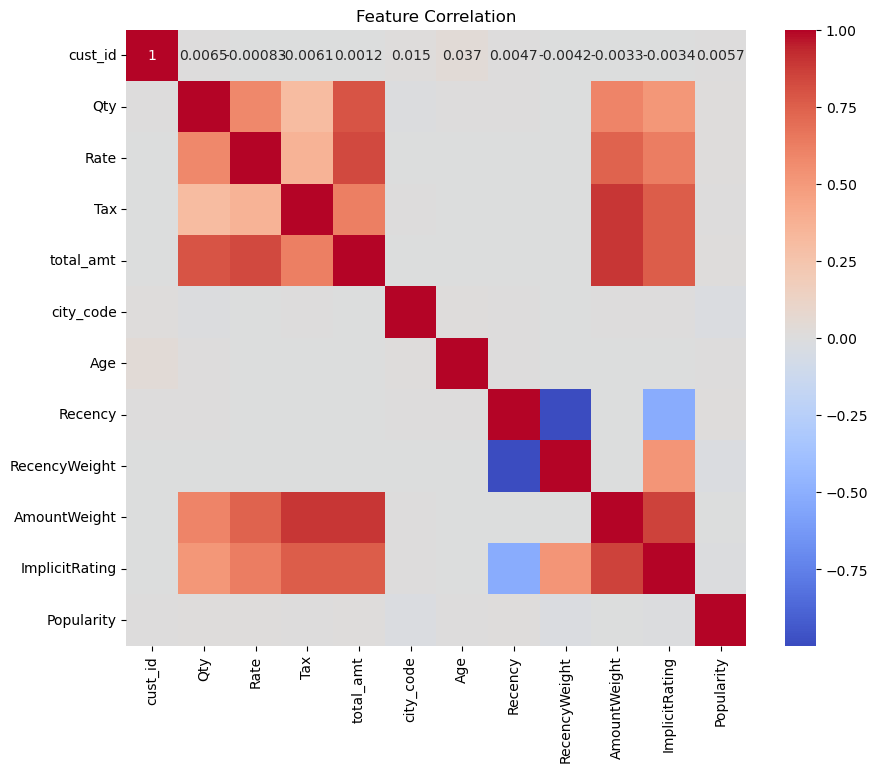

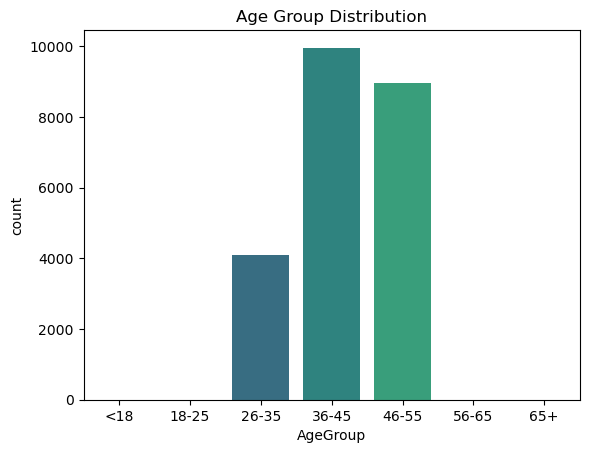

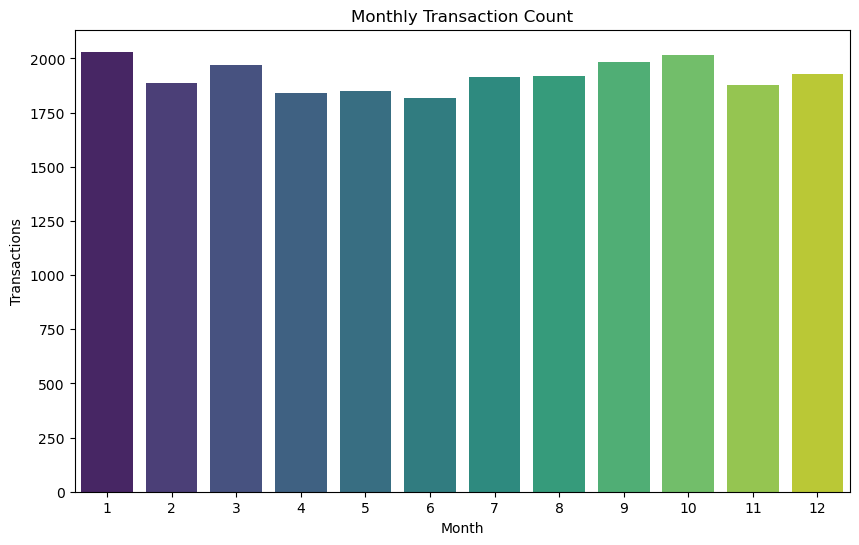

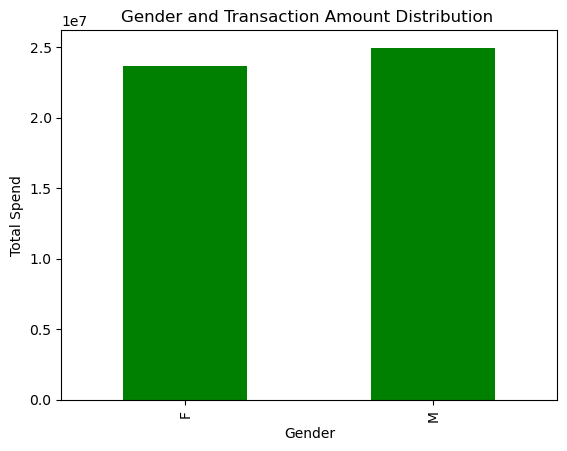

In [116]:
# Initialize RecommendationSystem object
rec_system = RecommendationSystem(
    customer_file='Customer.csv', 
    product_file='prod_cat_info.csv', 
    transaction_file='Transactions.csv'
)

# Prepare Data
rec_system.prepare_data()
rec_system.compute_popularity()
rec_system.compute_demographic_popularity()

# Perform Exploratory Data Analysis
rec_system.perform_eda()

# Inferences from EDA
1. Maximum  shopping age group is 36 - 45
2. No monthwise trends noticed
3. No Imbalance noticed in genderwise spend


User-Item Matrices created.
Item similarity matrix shape: (23, 23)
SVD applied and hybrid scores generated.
TF-IDF Matrix Shape: (23, 11)
TF-IDF hybrid scores computed.
SVM models trained.
Advanced Evaluation Metrics:
                      Precision@K  Recall@K       MRR      NDCG      F1@K
KNN                      0.342554  0.984301  1.000000  0.986935  0.487853
SVM                      0.147021  0.414371  0.306444  0.273455  0.208283
SVD                      0.325173  0.947965  0.958954  0.891801  0.464822
TfIdf                    0.237722  0.713190  0.596690  0.544032  0.341840
Hybrid_SVD_KNN           0.325173  0.947965  0.958954  0.891801  0.464822
Hybrid_TfIdf_SVD         0.291700  0.866939  0.920283  0.803630  0.418627
Hybrid_KNN_SVD_TfIdf     0.318434  0.931660  0.953411  0.877319  0.455495


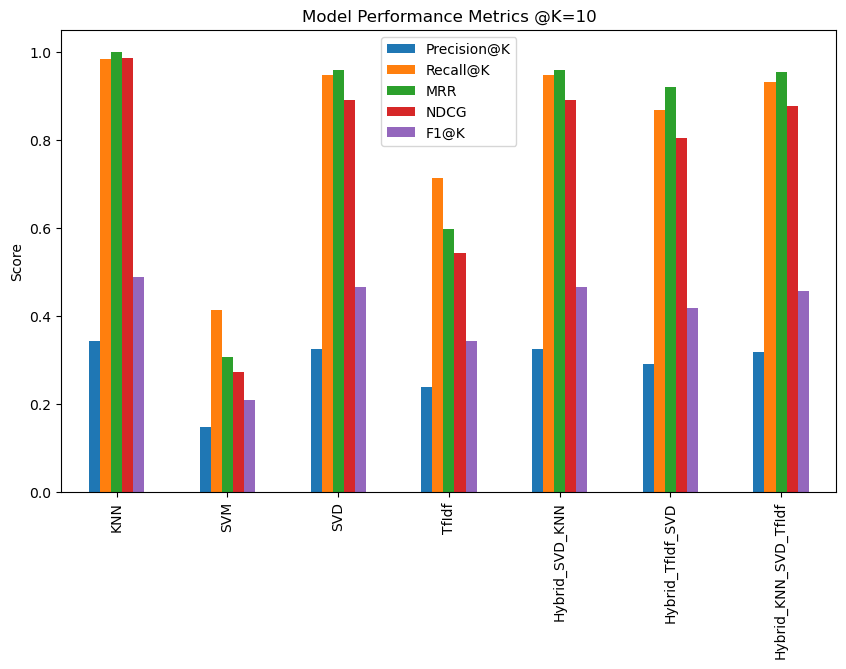

In [118]:

# Create User-Item Matrix
rec_system.create_user_item_matrix()

# Compute Item Similarities
rec_system.compute_item_similarity()

# Apply SVD for Latent Factor Analysis
rec_system.apply_svd()

# Compute TF-IDF Hybrid Scores
rec_system.compute_tfidf_similarity()

# Train SVM models (assuming training data is available)
rec_system.train_svm()

# Assuming we have a test set for evaluation, here is how to evaluate different models:
test_data = rec_system.user_item_matrix_weighted.to_dict(orient='index')

# Example model predictions (for testing purposes)
knn_predictions = {user_id: rec_system.knn_recommendations(user_id) for user_id in test_data.keys()}
svm_predictions = {user_id: rec_system.recommend_svm(user_id) for user_id in test_data.keys()}
svd_predictions = {user_id: rec_system.recommend_svd(user_id, top_n=10) for user_id in test_data.keys()}
tfIdf_predictions = {user_id: rec_system.recommend_tfIdf(user_id) for user_id in test_data.keys()}
hybrid_knn_svd_predictions = {user_id: rec_system.hybrid_knn_svd(user_id) for user_id in test_data.keys()}
hybrid_tfIdf_svd_predictions = {user_id: rec_system.hybrid_tfIdf_svd(user_id) for user_id in test_data.keys()}
hybrid_knn_svd_tfidf_predictions = {user_id: rec_system.hybrid_knn_svd_tfidf(user_id) for user_id in test_data.keys()}


# Combine all model predictions into a dictionary
model_predictions = {
    'KNN': knn_predictions,
    'SVM': svm_predictions,
    'SVD': svd_predictions,
    'TfIdf': tfIdf_predictions,
    'Hybrid_SVD_KNN': hybrid_knn_svd_predictions,
    'Hybrid_TfIdf_SVD' : hybrid_tfIdf_svd_predictions,
    'Hybrid_KNN_SVD_TfIdf' : hybrid_knn_svd_tfidf_predictions
}

# Step 7: Compare Model Performance
metrics_df = rec_system.evaluate_advanced_metrics(model_predictions, test_data, k=10)


In [110]:

# Find the best-performing model
best_model = metrics_df['F1@K'].idxmax()
print(f"The best-performing model is: {best_model}")

The best-performing model is: KNN


In [111]:
#user specific recommendation based on hybrid model
user_id = 275262
top_n = 4
recommendation  = rec_system.hybrid_knn_svd_tfidf(user_id,top_n=top_n)
print(f"Top {top_n} Recommendations for {user_id}:", print_recommendation(recommendation))

Top 4 Recommendations for 275262: ['Electronics-Cameras', 'Clothing-Mens', 'Electronics-Computers', 'Home and kitchen-Tools']


In [112]:
# Example cold start recommendations
# For a user with age group '18-25' and gender 'Male'
age_group = '36-45'
gender = 'M'
cold_start_recs = rec_system.recommend_cold_start(age_group=age_group, gender=gender, top_n=5)
print("Cold Start Recommendations:", print_recommendation(cold_start_recs))


Recommendations for Age Group: 36-45, Gender: M
Cold Start Recommendations: ['Clothing-Mens', 'Electronics-Cameras', 'Clothing-Women', 'Books-Comics', 'Electronics-Mobiles']


In [113]:
# For a user without demographic data
global_recs = rec_system.recommend_cold_start(top_n=5)
print("Global Popularity Recommendations:", print_recommendation(global_recs))

Falling back to global popularity recommendations.
Global Popularity Recommendations: ['Books-Fiction', 'Electronics-Mobiles', 'Books-Children', 'Home and kitchen-Tools', 'Footwear-Women']
